In [77]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
np.set_printoptions(suppress=True)

1.  Opis problemu, skąd pomysł, źródło danych
2. Wstępną analizę danych (histogramy, scatterploty, macierz korelacji między zmiennymi mierzonymi na skali ilorazowej, podstawowe statystyki opisowe: średnia, mediana, kwartyle, minimum, maksimum, współczynnik zmienności dla każdej zmiennej). Do wszystkiego ma być dorzucona interpretacja.
3. Faktyczną analizę

a.       W przypadku projektu z analizy skupień (ćwiczenia 1): Grupowanie metodą k-średnich (dla różnych wartości k), wraz z oceną jakości dopasowania dostępnymi metrykami (Silhouette, Caliński-Harabasz, wewnątrzgrupowa suma kwadratów). Na podstawie analizy wybrać odpowiednie k, i zwizualizować grupowanie dla 3 wybranych zmiennych (jeśli jest ich więcej). Centra klastrów zinterpretować (‘przeciętni przedstawiciele klastra’). Przeprowadzić również analizę skupień za pomocą metody aglomeracyjnej z użyciem różnych metod łączenia klastrów (np: ‘single’, ‘average’, ‘ward’, ‘median’), dokonać porównania, przedstawić dendrogramy wraz z opisem i decyzją ile klastrów powinno zostać wykorzystanych. Dodatkowo (dla chętnych): dorzucić dodatkowy algorytm klastrowania, np. DBScan, K-Medoids, MeanShift.

opis problemu, skad pomysł - #TODO

#### źródło danych - https://www.kaggle.com/nadintamer/top-spotify-tracks-of-2018
#### na stronie można też znaleźć opis kolumn

In [41]:
data = pd.read_csv('top2018.csv')

In [6]:
data.head()

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,6DCZcSspjsKoFjzjrWoCd,God's Plan,Drake,0.754,0.449,7.0,-9.211,1.0,0.1090,0.0332,0.000083,0.552,0.357,77.169,198973.0,4.0
1,3ee8Jmje8o58CHK66QrVC,SAD!,XXXTENTACION,0.740,0.613,8.0,-4.880,1.0,0.1450,0.2580,0.003720,0.123,0.473,75.023,166606.0,4.0
2,0e7ipj03S05BNilyu5bRz,rockstar (feat. 21 Savage),Post Malone,0.587,0.535,5.0,-6.090,0.0,0.0898,0.1170,0.000066,0.131,0.140,159.847,218147.0,4.0
3,3swc6WTsr7rl9DqQKQA55,Psycho (feat. Ty Dolla $ign),Post Malone,0.739,0.559,8.0,-8.011,1.0,0.1170,0.5800,0.000000,0.112,0.439,140.124,221440.0,4.0
4,2G7V7zsVDxg1yRsu7Ew9R,In My Feelings,Drake,0.835,0.626,1.0,-5.833,1.0,0.1250,0.0589,0.000060,0.396,0.350,91.030,217925.0,4.0


Usunięcie kolumn, które zawierają tekst i nie będą analizowane (spotify URI, tytuł oraz artysta)

In [42]:
data = data.drop(columns=['id','name','artists'])

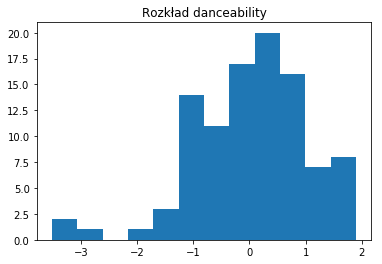

In [24]:
data['danceability'].hist(bins=12)
plt.title('Rozkład danceability')
plt.grid(None)
plt.show()

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

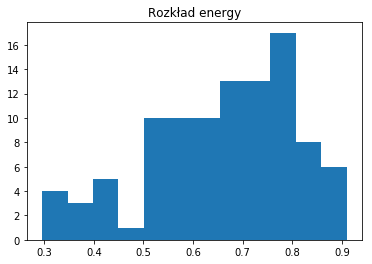

In [9]:
data['energy'].hist(bins=12)
plt.title('Rozkład energy')
plt.grid(None)
plt.show()

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

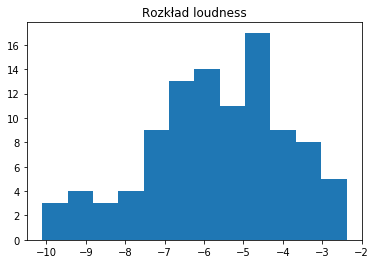

In [10]:
data['loudness'].hist(bins=12)
plt.title('Rozkład loudness')
plt.grid(None)
plt.show()

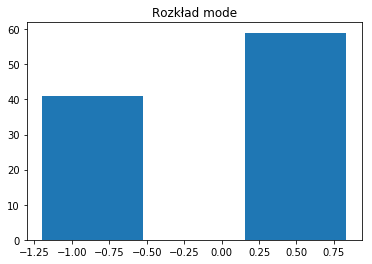

In [36]:
data['mode'].hist(bins=3)
plt.title('Rozkład mode')
plt.grid(None)
plt.show()

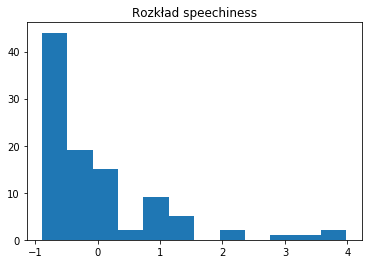

In [26]:
data['speechiness'].hist(bins=12)
plt.title('Rozkład speechiness')
plt.grid(None)
plt.show()

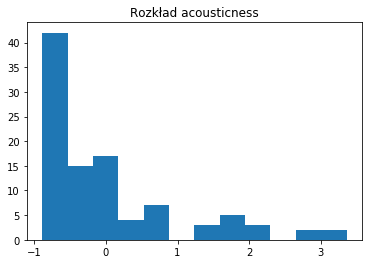

In [27]:
data['acousticness'].hist(bins=12)
plt.title('Rozkład acousticness')
plt.grid(None)
plt.show()

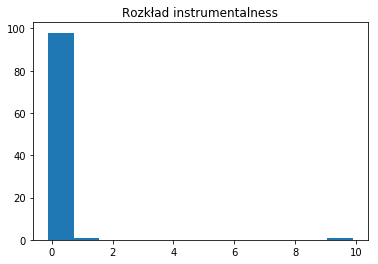

In [28]:
data['instrumentalness'].hist(bins=12)
plt.title('Rozkład instrumentalness')
plt.grid(None)
plt.show()

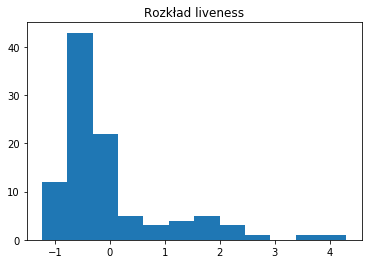

In [29]:
data['liveness'].hist(bins=12)
plt.title('Rozkład liveness')
plt.grid(None)
plt.show()

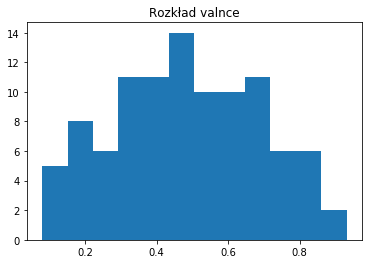

In [52]:
data['valence'].hist(bins=12)
plt.title('Rozkład valnce')
plt.grid(None)
plt.show()

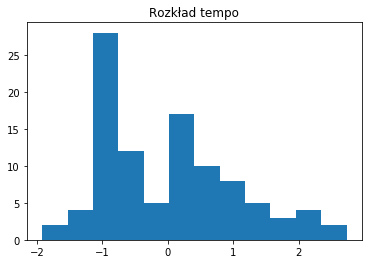

In [30]:
data['tempo'].hist(bins=12)
plt.title('Rozkład tempo')
plt.grid(None)
plt.show()

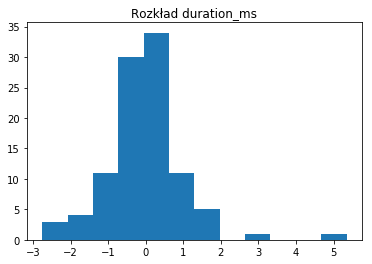

In [31]:
data['duration_ms'].hist(bins=12)
plt.title('Rozkład duration_ms')
plt.grid(None)
plt.show()

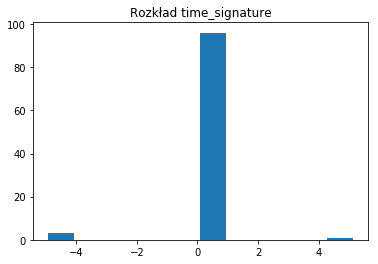

In [32]:
data['time_signature'].hist(bins=12)
plt.title('Rozkład time_signature')
plt.grid(None)
plt.show()

#### Usuwamy kolumny, w ktorych dane skupiają się wokół jednej wartości. Mniejsza liczba kolumn ułatwi analize, a skoro wartości dla każdego rekordu są podobne lub takie same nie wniosą wiele do analizy. 

In [44]:
data = data.drop(columns=['instrumentalness','time_signature','liveness'])

In [45]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,valence,tempo,duration_ms
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.71646,0.659060,5.330000,-5.677640,0.590000,0.115569,0.195701,0.484443,119.904180,205206.780000
std,0.13107,0.145067,3.676447,1.777577,0.494311,0.104527,0.220946,0.206145,28.795984,40007.893404
min,0.25800,0.296000,0.000000,-10.109000,0.000000,0.023200,0.000282,0.079600,64.934000,95467.000000
25%,0.63550,0.562000,1.750000,-6.650500,0.000000,0.045350,0.040225,0.341000,95.730750,184680.000000
50%,0.73300,0.678000,5.000000,-5.566500,1.000000,0.074950,0.109000,0.470500,120.116000,205047.500000
75%,0.79825,0.772250,8.250000,-4.363750,1.000000,0.137000,0.247750,0.641500,140.022750,221493.250000
max,0.96400,0.909000,11.000000,-2.384000,1.000000,0.530000,0.934000,0.931000,198.075000,417920.000000


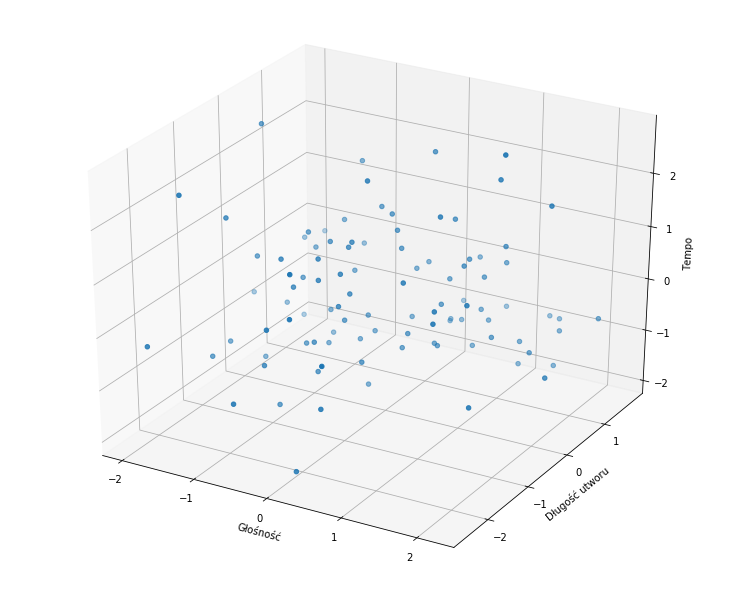

In [38]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)
ax.scatter(data['valence'], data['energy'], data['tempo'])
ax.set_xlabel('Głośność')
ax.set_ylabel('Długość utworu')
ax.set_zlabel('Tempo')
plt.show()

## Standaryzacja danych
### Od każdej zmiennej odejmujemy średnią, i dzielimy przez jej odchylenie standardowe

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data)

In [47]:
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,valence,tempo,duration_ms
0,0.287854,-1.455314,0.456531,-1.997753,0.833616,-0.063162,-0.739184,-0.621334,-1.491544,-0.156599
1,0.180503,-0.319108,0.729903,0.450984,0.833616,0.282982,0.283383,-0.055789,-1.566444,-0.969690
2,-0.992691,-0.859498,-0.090213,-0.233147,-1.199593,-0.247772,-0.357995,-1.679294,1.394085,0.325071
3,0.172835,-0.693224,0.729903,-1.319276,0.833616,0.013759,1.748092,-0.221552,0.705712,0.407795
4,0.908957,-0.229043,-1.183701,-0.087840,0.833616,0.090680,-0.622280,-0.655462,-1.007767,0.319494


### Klastrowanie metodą k-średnich

In [78]:
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(data)
print(kmeans_3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [79]:
kmeans_3.labels_

array([2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 1, 0, 0, 2, 2, 1, 0,
       1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 2, 0, 1, 0,
       0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2], dtype=int32)

In [80]:
kmeans_6 = KMeans(n_clusters=6)
kmeans_6.fit(data)
print(kmeans_6)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [81]:
kmeans_6.labels_

array([1, 1, 4, 2, 1, 4, 0, 0, 1, 0, 1, 2, 3, 1, 3, 1, 0, 0, 5, 1, 3, 0,
       3, 0, 0, 3, 4, 4, 5, 1, 1, 0, 4, 1, 3, 2, 4, 0, 2, 4, 0, 3, 4, 4,
       3, 3, 3, 4, 0, 4, 1, 3, 2, 0, 0, 5, 3, 3, 0, 0, 3, 1, 1, 4, 4, 4,
       3, 0, 0, 3, 3, 3, 1, 1, 4, 4, 4, 3, 3, 1, 2, 4, 1, 3, 2, 0, 1, 0,
       0, 1, 0, 5, 2, 4, 5, 1, 1, 4, 4, 2], dtype=int32)

In [82]:
kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(data)
print(kmeans_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [83]:
kmeans_2.labels_

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

### Ocena jakości klastrów na podstawie trzech metryk:

#### 1. silhouette

In [85]:
silhouette_3 = metrics.silhouette_score(data, kmeans_3.labels_, metric='euclidean')
silhouette_6 = metrics.silhouette_score(data, kmeans_6.labels_, metric='euclidean')
silhouette_2 = metrics.silhouette_score(data, kmeans_2.labels_, metric='euclidean')

#### 2. wewnątrzgrupowa suma kwadratów

In [87]:
inertia_3 = kmeans_3.inertia_
inertia_6 = kmeans_6.inertia_
inertia_2 = kmeans_2.inertia_

#### 3. Caliński-Harabasz

In [89]:
calinski_harabaz_3 = metrics.calinski_harabaz_score(data, kmeans_3.labels_)
calinski_harabaz_6 = metrics.calinski_harabaz_score(data, kmeans_6.labels_)
calinski_harabaz_2 = metrics.calinski_harabaz_score(data, kmeans_2.labels_)

#### Tabela porównująca wszystkie wartości dla różnej liczby klastrów

In [98]:
pd.DataFrame(np.array([[3, silhouette_3, inertia_3, calinski_harabaz_3], [6, silhouette_6, inertia_6, calinski_harabaz_6], [2, silhouette_2, inertia_2, calinski_harabaz_2]]),
             columns=['liczba klastrów', 'silhouette', 'inertia','calinski_harabaz'])


,liczba klastrów,silhouette,inertia,calinski_harabaz
0,3.0,0.133222,753.339671,15.879989
1,6.0,0.128469,596.907362,12.695675
2,2.0,0.146505,844.990422,17.977646


#### Interpretacja tabeli:
#### Metodami 'silhouette' oraz 'Caliński-Harabasz' najkorzystniejsze wartości dla dwóch klastrów. W przypadku metody  wewnątrzgrupowej sumy kwadratów najkorzystniejszą wartość otrzymaliśmy dla 6 klastrów, jednak w tej metodzie korzystne jest też wybranie małej liczby klastrów, dlatego zdecydowaliśmy się na 2. 

In [20]:
kmeans.cluster_centers_

array([[-1.21250558, -1.45993254,  0.09203525, -0.29647191,  0.83361577,
        -0.83717731,  0.86866026, -0.11834251,  0.31230708, -1.23075777,
        -0.4144677 ,  1.1363283 , -4.92468529],
       [ 0.06701778,  0.43355964,  0.82831728,  0.34692799, -0.95560832,
         0.15679347, -0.32708546, -0.11404915,  0.01920754,  0.11718972,
         0.33020307,  0.3131286 ,  0.10050378],
       [-0.08494272,  0.63656072, -0.65303756,  0.75644817,  0.29541334,
        -0.34561936, -0.23701107, -0.1070131 ,  0.104761  ,  0.4757717 ,
        -0.45836314, -0.01750971,  0.24830346],
       [-1.33966557, -1.25959538,  0.62738883, -1.26443267, -0.43713998,
        -0.10090088,  1.96302207, -0.11813075, -0.16281858, -0.57032542,
        -0.33646169, -0.54671196,  0.10050378],
       [ 0.56627992, -0.66049508, -0.08078615, -0.8229351 ,  0.48306246,
         0.40827679, -0.04189529, -0.07261459, -0.12326583, -0.34115062,
         0.33054588, -0.20049981,  0.10050378],
       [-0.85466845,  1.128862

##### centra skupień

In [21]:
scaler.inverse_transform(kmeans.cluster_centers_)

array([[     0.55833333,      0.44833333,      5.66666667,
            -6.202     ,      1.        ,      0.0285    ,
             0.38666667,      0.        ,      0.193     ,
             0.232     ,    108.029     , 250441.        ,
             3.        ],
       [     0.7252    ,      0.72164   ,      8.36      ,
            -5.06404   ,      0.12      ,      0.131876  ,
             0.1237952 ,      0.00005745,      0.160436  ,
             0.50848   ,    129.36504   , 217671.6       ,
             4.        ],
       [     0.70538235,      0.75094118,      2.94117647,
            -4.33973529,      0.73529412,      0.07962353,
             0.14359706,      0.0001516 ,      0.16994118,
             0.58202941,    106.77132353, 204509.76470588,
             4.02941176],
       [     0.54175   ,      0.47725   ,      7.625     ,
            -7.914     ,      0.375     ,      0.105075  ,
             0.62725   ,      0.00000283,      0.1402125 ,
             0.3674625 ,    110.264  

## 1 grupa - smutny nastroj, srednia energia, niskie tempo
## 2 grupa - wyzszy nastroj. wysoka energia, roznorodne tempo 

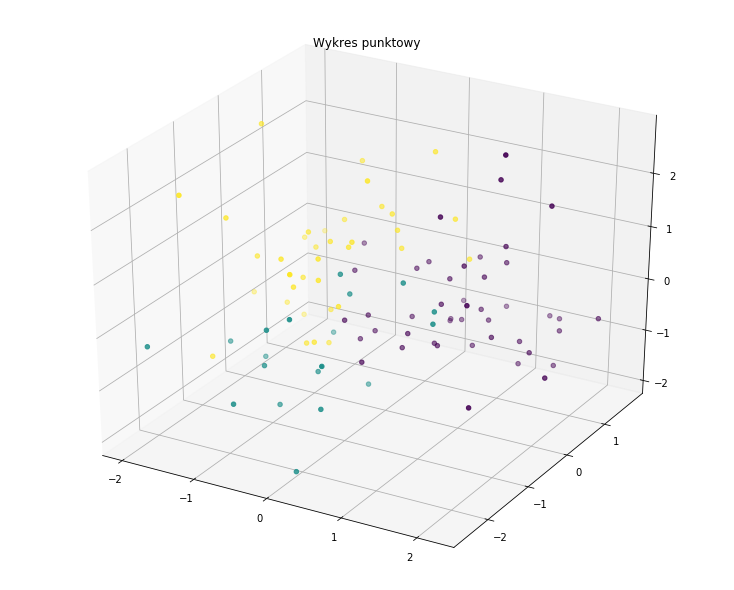

In [59]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(
    data['valence'],
    data['energy'],
    data['tempo'],
    c=kmeans.labels_
)
plt.title('Wykres punktowy')
plt.show()